In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
print(tf.__version__)

import keras
from keras import layers

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


2.13.1


In [2]:
# Download the dataset
dataframe = pd.read_csv('df.csv')
dataframe.head()

N = 80
# Select first N columns
df_first_n_column  = dataframe.iloc[: , :N]
df_first_n_column.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,3.292550,1.129386,1.127192,2.943257,2.881993,1.281398,-1.433339,-0.977916,2.044927,2.084133,...,1.089455,2.915268,0.443536,0.0,-1.455104,-0.865331,0.000000,0.0,0.0,0.000000
1,5.948631,2.073620,1.148361,-2.407923,4.347328,2.692258,1.795444,0.656688,2.991314,0.878747,...,1.092359,-2.366027,1.283676,0.0,1.092359,-2.366027,0.000000,0.0,0.0,0.000000
2,1.962838,11.126064,-4.037154,2.058677,1.473886,7.474912,-3.925822,-0.184088,1.406231,11.259674,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,1.383198,0.775613,-1.688025,1.653960,1.221781,0.447371,-1.204657,0.180370,0.703561,0.201996,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,6.019484,1.706356,-0.880597,-2.931689,4.097297,1.360899,1.086409,-0.616527,3.119764,0.659620,...,-0.894729,-2.905498,1.511874,0.0,-0.894729,-2.905498,50.345768,0.0,0.0,-0.044842


In [3]:
data = df_first_n_column.to_numpy()

#remove the rare events where any of the entries is nan
data = data[~np.isnan(data).any(axis=1), :]

print(data)
print(data.shape)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=21)


[[ 3.29255028  1.12938622  1.12719238 ...  0.          0.
   0.        ]
 [ 5.94863091  2.07361969  1.14836097 ...  0.          0.
   0.        ]
 [ 1.96283817 11.12606445 -4.0371542  ...  0.          0.
   0.        ]
 ...
 [ 3.90005188  4.71358795  2.48476577 ...  0.          0.
   0.        ]
 [ 1.71831036  0.38169449 -0.4257378  ...  0.          0.
  -1.41709948]
 [ 5.85582809 11.959823   -3.01419187 ...  0.          0.
  -0.91258603]]
(209805, 80)


In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

print(np.isnan(train_data).any())

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

False


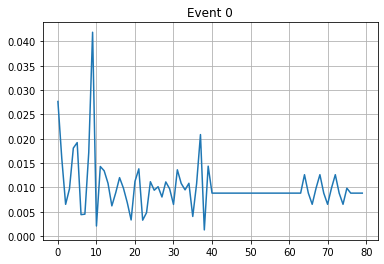

In [5]:
plt.grid()
plt.plot(np.arange(N), train_data[2])
plt.title("Event 0")
plt.show()

In [6]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(N, activation="tanh"),
      #layers.Dense(40, activation="relu"),
      #layers.Dense(20, activation="relu")
      #layers.Dense(16, activation="relu")
      layers.Dense(N/4, activation="tanh")
       ])

    self.decoder = tf.keras.Sequential([
      #layers.Dense(20, activation="relu"),
      #layers.Dense(40, activation="relu"),
      layers.Dense(N, activation="tanh")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [7]:
opt = keras.optimizers.Adam(learning_rate=0.005)
autoencoder.compile(optimizer=opt, loss='mae')

In [ ]:
history = autoencoder.fit(train_data, train_data, 
          epochs=30, 
          batch_size=128,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/30
1312/1312 [==============================] - 3s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 2/30
1312/1312 [==============================] - 2s 2ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 3/30
1312/1312 [==============================] - 2s 2ms/step - loss: 9.9644e-04 - val_loss: 9.7010e-04
Epoch 4/30
1312/1312 [==============================] - 3s 2ms/step - loss: 9.7096e-04 - val_loss: 0.0010
Epoch 5/30
1312/1312 [==============================] - 2s 2ms/step - loss: 9.5874e-04 - val_loss: 9.4777e-04
Epoch 6/30
1312/1312 [==============================] - 3s 2ms/step - loss: 9.4768e-04 - val_loss: 9.7277e-04
Epoch 7/30
1312/1312 [==============================] - 3s 2ms/step - loss: 9.4498e-04 - val_loss: 0.0010
Epoch 8/30
1312/1312 [==============================] - 3s 2ms/step - loss: 9.4172e-04 - val_loss: 9.9156e-04
Epoch 9/30
1312/1312 [==============================] - 3s 2ms/step - loss: 9.3314e-04 - val_loss: 9.5941e-04
Epoch 10/30
1312/1312 [===========

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.yscale("log")
plt.legend()

In [ ]:
encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

randIndx = 6

plt.plot(test_data[randIndx], 'b')
#plt.plot(encoded_data[randIndx], 'r')
plt.plot(decoded_data[randIndx], 'r')
#plt.fill_between(np.arange(N), encoded_data[randIndx], test_data[randIndx], color='lightcoral')
plt.fill_between(np.arange(N), decoded_data[randIndx], test_data[randIndx], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
min_ind = tf.argmin(test_loss)
max_ind = tf.argmax(test_loss)

#print(test_data[min_ind])

In [ ]:
ind = min_ind

plt.plot(test_data[ind], 'b')
plt.plot(decoded_data[ind], 'r')
ratio = (test_data[ind] / decoded_data[ind])
#plt.plot(ratio, 'r')

plt.fill_between(np.arange(N), decoded_data[ind], test_data[ind], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
#plt.yscale("log")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Mean: ", np.mean(train_loss))
print("Threshold: ", threshold)

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print(preds)
print_stats(preds, test_labels)